<a href="https://colab.research.google.com/github/dbahiense/DIO/blob/main/11RetrainingVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import necessary libraries
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

Config and Metadata

In [2]:
#config and metadata
#image size
IMAGE_SIZE = 224

In [3]:
#image shape
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [4]:
#image batch size
IMG_BATCH_SIZE = 1

In [5]:
#batch size
BATCH_SIZE = 32

In [6]:
#shuffle buffer size
SHUFFLE_BUFFER_SIZE = 1000

In [7]:
#base learning rate
BASE_LEARNING_RATE = 0.0001

In [8]:
#trainging epochs
TRAINING_EPOCHS = 20

In [9]:
#get data
#add this line, as suggested in https://stackoverflow.com/a/72458771, to solve DownloadError
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [10]:
#split raw data in training, validation and test groups
(raw_training, raw_validation, raw_testing), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteSIFZRO/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [11]:
#resize image and convert it into a form that tensorflow can read more easily 
def prep_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

In [12]:
#create training, validation and testing data from raw data
training_data = raw_training.map(prep_image)
validation_data = raw_validation.map(prep_image)
testing_data = raw_testing.map(prep_image)

In [13]:
#create batches
training_batches = training_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
testing_batches = testing_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
#import the original VGG16 model and remove its top layer
original_model = tf.keras.applications.VGG16(include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [15]:
#don't retrain the original model
original_model.trainable = False

In [16]:
#add first new layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [17]:
#add second new layer
prediction_layer = tf.keras.layers.Dense(2)

In [18]:
#combining the two new layers with the original model
model = tf.keras.Sequential([
  original_model,
  global_average_layer,
  prediction_layer
])

In [19]:
#compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LEARNING_RATE), #changed lr to learning_rate as lr is deprecated
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
#check compilation
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#use GPU and train model
with tf.device('/device:GPU:0'):
  history = model.fit(training_batches,
                      epochs=TRAINING_EPOCHS,
                      validation_data=validation_batches)

Epoch 1/20
582/582 [==============================] - 143s 219ms/step - loss: 0.9069 - accuracy: 0.6288 - val_loss: 0.6263 - val_accuracy: 0.8401
Epoch 2/20
582/582 [==============================] - 129s 218ms/step - loss: 0.6528 - accuracy: 0.8557 - val_loss: 0.6754 - val_accuracy: 0.8874
Epoch 3/20
582/582 [==============================] - 128s 218ms/step - loss: 0.6270 - accuracy: 0.8860 - val_loss: 0.6249 - val_accuracy: 0.9011
Epoch 4/20
582/582 [==============================] - 128s 217ms/step - loss: 0.6266 - accuracy: 0.8893 - val_loss: 0.5818 - val_accuracy: 0.8925
Epoch 5/20
582/582 [==============================] - 128s 218ms/step - loss: 0.6097 - accuracy: 0.8876 - val_loss: 0.6085 - val_accuracy: 0.8990
Epoch 6/20
582/582 [==============================] - 128s 217ms/step - loss: 0.6127 - accuracy: 0.8903 - val_loss: 0.5792 - val_accuracy: 0.9007
Epoch 7/20
582/582 [==============================] - 128s 217ms/step - loss: 0.5720 - accuracy: 0.8934 - val_loss: 0.5633 -

In [21]:
#get image function
def get_image_from_url(image_url):
  # If the temporary test_image.jpg file already exists, 
  # delete it so a new one can be made.
  if os.path.exists('/root/.keras/datasets/test_image.jpg'):
    os.remove('/root/.keras/datasets/test_image.jpg')

  image_path = tf.keras.utils.get_file('test_image.jpg', origin=image_url)
  return image_path

In [22]:
#print prediction function
def print_predictions(predictions):
    for (prediction, number) in zip(predictions[0], range(1, len(predictions[0])+1)):
      print('{}. {} {:.2f}%'.format(number, prediction[1], prediction[2]*100))

In [23]:
#predict image function
def predict_image(image_url):
  #fetch image from URL using the above get image function
  image_path = get_image_from_url(image_url)

  #prepare image for use by the model
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))

  #create a new figure, or activate an existing one
  #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html
  plt.figure()

  #display data as an image, i.e., on a 2D regular raster.
  #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
  plt.imshow(image)

  #transform image into an array
  image = tf.keras.preprocessing.image.img_to_array(image)
  image = np.expand_dims(image, axis=0)

  #prediction result
  prediction_result = model.predict(image, batch_size=IMG_BATCH_SIZE)
  labels = metadata.features['label'].names
  print(labels[prediction_result.argmin()])

180224/166544 [================================] - 0s 0us/step
dog


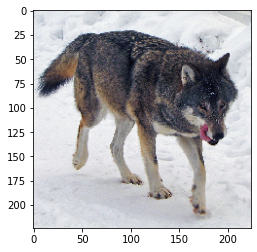

In [25]:
#make prediction
predict_image('https://upload.wikimedia.org/wikipedia/commons/5/5f/Kolm%C3%A5rden_Wolf.jpg')